# 23 RNNs for Language Data

*Code largely adapted from https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html*

1994 Super Famicom Fighting Baseball: The game included the 1993 season's major league players and stats thanks to its MLBPA license. The Japanese version of Fighting Baseball, did *not* have the MLBPA licence. Therefore they couldn't use player names.  Instead, someone had to make up plausibly "American"-sounding names.

<img src="https://i.imgur.com/KJJOKTS.jpeg">

Tag yourself, I'm Mike Truk.

Let's take a look at some "American" (English) names.

We need to import some data, so we'll use the same data we'll use in the implementation later.

In [567]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import numpy as np
import os
import pandas
import unicodedata
import string

In [543]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker
print("%s letters: [%s]" % (n_letters, all_letters))

59 letters: [abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'-]


In [544]:
def findFiles(path):
    return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [545]:
# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/surnames/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)

# categories: 19 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Hindi', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


In [546]:
# test non-ASCII character handling
# slightly problematic choice
# using 'n' for 'ñ' is like deciding it's not importatnt to type Ts anymore
print(unicodeToAscii("O'Néàl"))

O'Neal


Take a random sampling of names from each category:

In [631]:
choices = {language : [int(np.random.uniform()*len(category_lines[language])) for i in range(10)] for language in all_categories}
choices = {language : [category_lines[language][c] for  c in choices[language]] for language in choices}
df = pandas.DataFrame(choices)
df

,Arabic,Chinese,Czech,Dutch,English,French,German,Greek,Hindi,Irish,Italian,Japanese,Korean,Polish,Portuguese,Russian,Scottish,Spanish,Vietnamese
0,Koury,Bian,Victor,Ven,Lyon,Robert,Rosenberger,Banos,Ramakan,Raghailligh,Nicolosi,Isobe,Jang,Gorka,Barros,Avtukhov,Jamieson,Elizondo,Ngo
1,Nazari,Chu,Weisener,Kloet,Timney,Deschamps,Vogel,Liatos,Medapati,Gallchobhar,Aquila,Sasaki,Choi,Nowak,Pinheiro,Jarikhin,Campbell,Mata,Quang
2,Nazari,Man,Kuffel,Paulis,Wickens,Sartre,Drechsler,Zouvelekis,Vinata,Niadh,Lecce,Shiga,Yeo,Sokolowski,De santigo,Babadjanyan,Cameron,Silva,Ngo
3,Nahas,Kau,Semick,Roggeveen,Ridle,Parent,Bohler,Poniros,Nergis,Ceallachan,Roma,Arakawa,Chung,Gorecki,Freitas,Aurov,Hunter,Armando,Hoang
4,Sabbag,Shan,Sabol,Nifterik,Karim,Faucher,Oppenheimer,Pantelas,Sritharan,O'Hannagain,Confortola,Tayama,Chun,Wojewodka,Almeida,Detengof,Craig,D'cruze,Vuu
5,Shamon,Lin,Krawiec,Kanne,Wareing,Foss,Lowe,Phocas,Malipatlolla,O'Keeffe,Alesci,Yoshikawa,Tsai,Pakulski,Guerra,Bacherikov,Davidson,Terrazas,Vinh
6,Bazzi,Zhu,Piller,Hanraets,Bannister,Guerin,Havener,Gavril,Barot,Flann,Adami,Sakoda,Jeong,Jelen,Magalhaes,Pismanik,Reid,Valencia,Van
7,Kattan,Seto,Neisser,Merckx,Reeve,Giroux,Bleier,Poniros,Kalpna,Eoghan,Longo,Oishi,Jo,Janda,Mata,Abutaliev,Bell,Maria,Chau
8,Sabbagh,Dan,Slapnickova,Snijders,Caton,Proulx,Meissner,Koumanidis,Shivani,Rinn,Pisani,Isobe,Suh,Szewc,Pereira,Talvir,Scott,Rivera,Nghiem
9,Cham,Wen,Jarzembowski,Aalst,Baxter,Fabian,Tangeman,Sotiris,Pyara,Maceachthighearna,Castro,Kawabata,Yu,Jordan,Albuquerque,Shamaev,Johnstone,Urbina,Vuu


How could we quantify the differences between these names?  Well, we could try counting characters.

In [632]:
import operator
{c : max({language : 
          sum([name.lower().count(c) for name in choices[language]]) 
          for language in all_categories}.items(), key=operator.itemgetter(1)) for c in all_letters[:26]}

{'a': ('Hindi', 18),
 'b': ('Arabic', 5),
 'c': ('Italian', 6),
 'd': ('Polish', 3),
 'e': ('German', 18),
 'f': ('French', 3),
 'g': ('Irish', 6),
 'h': ('Irish', 11),
 'i': ('Greek', 9),
 'j': ('Polish', 4),
 'k': ('Polish', 8),
 'l': ('Irish', 7),
 'm': ('German', 3),
 'n': ('Irish', 11),
 'o': ('Greek', 10),
 'p': ('Greek', 4),
 'q': ('Portuguese', 2),
 'r': ('German', 10),
 's': ('Greek', 10),
 't': ('Hindi', 5),
 'u': ('Vietnamese', 6),
 'v': ('Russian', 7),
 'w': ('Polish', 5),
 'x': ('French', 2),
 'y': ('English', 2),
 'z': ('Arabic', 4)}

So maybe a Hindi name should have more As and a Polish name has more Zs (makes sense...)

But...

$Aaaaa \leftarrow$ not a good Hindi name.

$Zzzzz \leftarrow$ not a good Polish name.

What matters is how the letters go together.

In [633]:
sample_eng = choices['English']
sample_eng

['Lyon',
 'Timney',
 'Wickens',
 'Ridle',
 'Karim',
 'Wareing',
 'Bannister',
 'Reeve',
 'Caton',
 'Baxter']

e.g., What's the probability that $l_t$, the letter at position $t$ is '$r$', given than $l_{t-1}$ is '$a$'?

$P(l_t=\textsf{'}r\textsf{'}|l_{t-1}=\textsf{'}a\textsf{'}) = ?$

$P(Y|X) = \frac{C(X,Y)}{C(X)}$

$P(\textsf{'}r\textsf{'}|\textsf{'}a\textsf{'}) = \frac{C(\textsf{'}a\textsf{'},\textsf{'}r\textsf{'})}{C(\textsf{'}a\textsf{'})}$

In [651]:
c1 = 'a'
c2 = 'r'

count1 = 0
count1_2 = 0
for name in sample_eng:
    for i in range(len(name)-1):
        count1_2 += np.sum(list(name.lower())[i:i+2] == [c1,c2])
        count1 += np.sum(list(name.lower())[i:i+1] == [c1])
print("%s across the above random sample" % (count1_2/count1))

count1 = 0
count1_2 = 0
for name in category_lines['English']:
    for i in range(len(name)-1):
        count1_2 += np.sum(list(name.lower())[i:i+2] == [c1,c2])
        count1 += np.sum(list(name.lower())[i:i+1] == [c1])
print("%s across all English names in the data" % (count1_2/count1))

0.4 across the above random sample
0.18038147138964578 across all English names in the data


### English

We know what spellings look like plausible English and what don't:

$V = \{e, g, p, r, s\}$

Plausible (fake) English words: $spreg$, $pregs$, $sperg$, $gresp$, $greps$.

Impossible English words: $sgerp$, $egrsp$, $psegr$, etc.

### Spanish or Welsh?

Both Spanish and Welsh use the digraph \<ll\>.

Talk this word beginning: *llan-*.  What comes next?

*Llan-* ***o***: Spanish for "plain".

*Llan-* ***f***: ???

 <span style="color:white">Llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch</span>

<img src="https://upload.wikimedia.org/wikipedia/commons/e/e8/Llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch_station_sign_%28cropped_version_1%29.jpg">

If you know a language, you have a lot of implicit knowledge about the patterns that fit that language, for example, the way words are formed (morphology), sentence structure (syntax), or how sounds fit together (phonotactics).

Spelling is a (very) rough approximation of phonotactics. **Order matters**.

A computer doesn't have any of this knowledge.  It must learn the order in which letters occur appropriately for the language.  How can we teach it from looking at a bunch of samples?

## Recurrent Neural Networks

Recurrent Neural Networks are generalizations of feedforward neural network that have "memory" in their hidden units. RNNs perform the same function for every input, but incorporate the output of the previous computation into the current one.

<img src="https://miro.medium.com/max/627/1*go8PHsPNbbV6qRiwpUQ5BQ.png">

$x_t$ is passed through the weights ${\bf A}$ to produce the output $h_t$.  ${\bf A}$ will be comprised of (at least) 3 individual weight matrices: ${\bf A}_i$, input layer weights; ${\bf A}_h$, hidden layer weights; and ${\bf A}_o$, output layer weights.

$$h_t = f({\bf A}_h h_{t-1}+{\bf A}_i x_t), \text{where } f \text{ is the activation function}$$

${\bf A}_h$ are hidden layer weights, so ${\bf H}$ ($h_t \in {\bf H}$) are hidden layer outputs that are included in the operation performed over the input ($x_t \in {\bf X}$) at the next timestep.

Output computation:
$$y_t = {\bf A}_o h_t$$

In [664]:
def softmax(x):
    return np.exp(x)/sum(np.exp(x))

In [877]:
# train a network to predict the following sequence: abc
lr = 0.1

# create target outputs as one-hot vectors (indicator variables)
letters = ['a','b','c']
T1 = np.array([0,1,0]) # b
T2 = np.array([0,0,1]) # c

# randomly initialize input hidden and output weights
Ai = np.random.rand(4,3)
Ah = np.random.rand(4,3)
Ao = np.random.rand(4,3)

# create input as one-hot vector
X = np.array([[1,0,0]]) # a
X = np.hstack([[[1]],X]) # add constant 1

output = []

H = np.tanh(X @ Ai)
H = np.hstack([[[1]],H]) # add constant 1
Y1 = softmax((H @ Ao).reshape(-1))
output.append(Y1)

Y1 = np.hstack([[1],Y1]) # add constant 1
H = np.tanh((H @ Ah) + (Y1 @ Ai))
H = np.hstack([[[1]],H]) # add constant 1
Y2 = softmax((H @ Ao).reshape(-1))
output.append(Y2)

print(output)
print(np.argmax(output,axis=1))

print("Starting weights:")
print(Ai)
print(Ah)
print(Ao)
print()

for i in range(1000):
    # compute hidden layer output
    H = np.tanh(X @ Ai)
    H = np.hstack([[[1]],H]) # add constant 1

    # compute first output and error
    Y1 = softmax((H @ Ao).reshape(-1))
    err1 = T1-Y1

    # NOW, compute hidden layer output using the second input
    Y1 = np.hstack([[1],Y1]) # add constant 1
    H = np.tanh((H @ Ah) + (Y1 @ Ai))
    H = np.hstack([[[1]],H]) # add constant 1

    # compute second output and error
    Y2 = softmax((H @ Ao).reshape(-1))
    err2 = T2-Y2
    
    Ai -= lr * ((err1/3) @ Ai.T * (1 - H ** 2)).reshape(-1,1)
    Ah -= lr * ((err1/3) @ Ah.T * (1 - H ** 2)).reshape(-1,1)
    Ao -= lr * ((err1/3) @ Ao.T).reshape(-1,1)
    
    Ai -= lr * ((err2/3) @ Ai.T * (1 - H ** 2)).reshape(-1,1)
    Ah -= lr * ((err2/3) @ Ah.T * (1 - H ** 2)).reshape(-1,1)
    Ao -= lr * ((err2/3) @ Ao.T).reshape(-1,1)
    
    if i % 100 == 0:
        print(letters[np.argmax(X.reshape(-1)[-3:])],letters[np.argmax(Y1[-3:])],letters[np.argmax(Y2[-3:])])

print("Ending weights:")
print(Ai)
print(Ah)
print(Ao)

output = []

H = np.tanh(X @ Ai)
H = np.hstack([[[1]],H]) # add constant 1
Y1 = softmax((H @ Ao).reshape(-1))
output.append(Y1)

Y1 = np.hstack([[1],Y1]) # add constant 1
H = np.tanh((H @ Ah) + (Y1 @ Ai))
H = np.hstack([[[1]],H]) # add constant 1
Y2 = softmax((H @ Ao).reshape(-1))
output.append(Y2)

print(output)
np.argmax(output,axis=1)

[array([0.2631355 , 0.28603912, 0.45082538]), array([0.21702309, 0.21279649, 0.57018042])]
[2 2]
Starting weights:
[[0.41830005 0.60531251 0.46598094]
 [0.04284437 0.42414691 0.58003034]
 [0.77477335 0.72047926 0.21837831]
 [0.50284881 0.96262374 0.08994456]]
[[0.84862148 0.96420535 0.43686078]
 [0.23316844 0.48079693 0.28488291]
 [0.29561181 0.83193022 0.22992977]
 [0.46565116 0.61042473 0.68453107]]
[[0.29833955 0.66231601 0.38350276]
 [0.19346552 0.15260902 0.88175455]
 [0.73745634 0.30316706 0.96774616]
 [0.12247239 0.21615862 0.09480255]]

a c c
a c c
a c c
a c c
a c c
a c c
a c c
a c c
a c c
a b c
Ending weights:
[[ 0.41830005  0.60531251  0.46598094]
 [-0.65687065 -0.27556811 -0.11968468]
 [ 0.81079648  0.7565024   0.25440144]
 [-0.87679125 -0.41701632 -1.2896955 ]]
[[ 0.84862148  0.96420535  0.43686078]
 [-0.15990944  0.08771905 -0.10819497]
 [ 0.17319641  0.70951481  0.10751437]
 [-0.12172172  0.02305186  0.09715819]]
[[-5.48534119 -5.12136473 -5.40017798]
 [ 0.25003305  0.209

array([1, 2], dtype=int64)

Training is very unreliable (try the above a few times---sometimes the output doesn't change much, or at all).  Rarely does it get it right.  Why?  We only have 1 sample!

Let's do something at scale using Pytorch!

In [878]:
import torch
import torch.nn as nn
import random

In [879]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1) # decrease odds of overfitting
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden # forward pass returns output value AND hidden layer value

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [880]:
# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair(all_cats,lines):
    category = randomChoice(all_cats)
    line = randomChoice(lines[category])
    return category, line

In [881]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

For convenience during training we’ll make a `randomTrainingExample` function that fetches a random (category, line) pair and turns them into the required (category, input, target) tensors.

In [882]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample(all_cats,lines):
    category, line = randomTrainingPair(all_cats,lines)
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

## Training the Network

In contrast to classification, where only the last output is used, we are making a prediction at every step, so we are calculating loss at every step.

The magic of autograd allows you to simply sum these losses at each step and call backward at the end.

In [883]:
criterion = nn.NLLLoss() # negative log likelihood loss

learning_rate = 0.0005

def train(model, category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    model.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = model(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in model.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

Add a `timeSince(timestamp)` function which returns a human readable string:

In [884]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [885]:
def output_to_letter(output):
    topv, topi = output.topk(1)
    topi = topi[0][0]
    if topi == n_letters - 1:
        letter = "\0"
    else:
        letter = all_letters[topi]
        
    return letter

Training is business as usual - call train a bunch of times and wait a few minutes, printing the current time and loss every `print_every` examples, and keeping store of an average loss per `plot_every` examples in `all_losses` for plotting later.

In [886]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 10000
print_every = 1000
plot_every = 100
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    ex = randomTrainingExample(all_categories,category_lines)
    output, loss = train(rnn,*ex)
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 3s (1000 10%) 3.5868
0m 7s (2000 20%) 3.6053
0m 10s (3000 30%) 3.4401
0m 14s (4000 40%) 2.8736
0m 17s (5000 50%) 2.7747
0m 21s (6000 60%) 3.2269
0m 24s (7000 70%) 2.9952
0m 28s (8000 80%) 3.3042
0m 31s (9000 90%) 2.8009
0m 35s (10000 100%) 2.9865


Let's plot the loss.

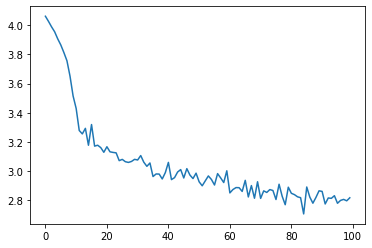

In [887]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Now let's generate some outputs, starting with each letter of the alphabet in turn.

In [890]:
max_length = 20

# Sample from a category and starting letter
def sample(category, model, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = model.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = model(category_tensor, input[0], hidden)
            letter = output_to_letter(output)
            if letter == "\0":
                break
            else:
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, model, start_letters='ABCDEFGHIJKLMNOPQRSTUVWXYZ'):
    print("%s:" % category)
    for start_letter in start_letters:
        s = [sample(category, model, start_letter) for i in range(3)]
        print('\t\t'.join(set(s)))
    print()

In [891]:
# there are the possible categories (languages)
cat_to_code = {}
for i in range(n_categories):
    cat_to_code[all_categories[i]] = all_categories[i][:3].upper()
print(cat_to_code)

{'Arabic': 'ARA', 'Chinese': 'CHI', 'Czech': 'CZE', 'Dutch': 'DUT', 'English': 'ENG', 'French': 'FRE', 'German': 'GER', 'Greek': 'GRE', 'Hindi': 'HIN', 'Irish': 'IRI', 'Italian': 'ITA', 'Japanese': 'JAP', 'Korean': 'KOR', 'Polish': 'POL', 'Portuguese': 'POR', 'Russian': 'RUS', 'Scottish': 'SCO', 'Spanish': 'SPA', 'Vietnamese': 'VIE'}


In [893]:
for cat in cat_to_code:
    samples(cat, rnn)

Arabic:
Aana		Aarar		Aarara
Barar
Cana		Cora		Carar
Daar		Dara
Earar		Earer
Farar
Garar
Harar		Hara
Ioan		Iarara		Iarar
Jarer		Jara
Kara
Larar		Lara		Laner
Mara		Marra
Nora		Narer
Ooara		Oarer		Oara
Parar		Para
Qarer		Qarera
Rarar
Sarar		Sara		Sarara
Taner		Toner		Tara
Uarar
Vara
Wana		Warar
Xarar
Yarar		Yara
Zarar		Zarer

Chinese:
Aaner		Aane		Aare
Bane		Bare
Caner		Cane
Don		Dan
Ean		Eane
Fane
Gane
Han
Iare		Iane
Jane		Jan		Jara
Kana		Kan
Lan		Lone
Mane		Man
Nane		Nere
Oane
Pon		Pare		Pan
Qane		Qaner
Ran
San
Ton		Tan
Uane		Uaan
Van		Vane
Wana		Wane
Xare		Xane
Yan
Zere		Zan		Zane

Czech:
Aarer		Aarar
Barar		Banara		Barer
Carer		Caner		Carere
Dorer		Darer
Eaner		Earoe		Earer
Farer		Farar
Gorer		Garer
Harer		Harere
Iarer
Jorer		Jarer		Janer
Karer		Kanar
Larer		Laree
Maree		Marar		Marere
Narer		Narar
Ooarere		Oanee		Oorer
Parer
Qarer		Qarar
Rarer		Rarere		Rareer
Sarer
Tarer
Uarer
Varar		Vaner		Varer
Warer
Xaneee		Xarar
Yarer		Yarere
Zarer

Dutch:
Aarer
Baen		Borer		Barer
Carer		Carere
Da

Well, that's not great.  It'd be hard to tell which language these "names" were supposed to be in.  Our model hasn't trained for long enough.

In [894]:
lastname_rnn = rnn

In [895]:
#torch.save(lastname_rnn,"lastname_rnn")

In [896]:
# load a better model - 512 hidden units, trained for 100,000 epochs (~10 mins)
lastname_rnn = torch.load("lastname_rnn")

In [898]:
for cat in cat_to_code:
    samples(cat, lastname_rnn)

Arabic:
Araha
Bara
Chara		Chari
Danar		Dana
Eana		Eara
Fara		Fanda		Foura
Gara
Hana		Houra
Iara		Iari
Jana		Jamar		Jour
Kouma		Karis		Kana
Lour		Lana
Mora		Mara
Namar
Ohara		Oaram		Oamar
Para
Quar		Qara		Qana
Ramar
Sama		Shama		Sana
Taram		Tamin		Tara
Uaram		Uara
Vana		Vanda		Varam
Wouran		Waram		Wanda
Xara		Xana		Xaram
Yana		Yanar
Zari		Zamar		Zana

Chinese:
Aun		Ang
Bau
Can		Chon		Cha
Dun		Don
Eun
Fa		Fun
Guang 		Guan		Guang
Han		Hann
Iunge		Iun
Jan
Ka		Kan
Lan
Man
Nan		Ning
Oha
Pai		Pan
Qun		Qan
Ran		Rou
Shan		Sha
Tan		Than
Uun		Uue
Van
Wange		Wan
Xin		Xun
Yan		Yai		Yau
Zhan

Czech:
Allan
Ballan		Balla
Challa		Chara		Care
Dallan		Daner
Erak		Eran
Faricha		Farich
Gorek		Garen		Garenck
Hander		Handent		Holla
Irane		Iran		Ialla
Jander		Janer
Kari		Kalla		Kolla
Lana		Lanerr		Laner
Mara
Nalle		Nalla
Ollan		Orrach		Ortan
Palle		Pare
Qarek		Qaren
Romall		Roman
Sallan		Salla		Salle
Tran
Uran		Urich
Villa		Vanter		Vanterk
Wolla		Walla
Xalla
Yonek		Yaner
Zana		Zaner

Dutch:
Anen		Aner
Beren
C

OK, so there are some plausible last names (maybe).  What about first names?  Let's load up some first name data and train the same network on this.

In [899]:
# Build the category_lines dictionary, a list of lines per category
fn_category_lines = {}
fn_all_categories = []
for filename in findFiles('data/firstnames/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    fn_all_categories.append(category)
    lines = readLines(filename)
    fn_category_lines[category] = lines

fn_n_categories = len(fn_all_categories)

if fn_n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', fn_n_categories, fn_all_categories)

# categories: 2 ['English', 'Spanish']


In [900]:
firstname_rnn = RNN(n_letters, 128, n_letters)

n_iters = 10000
print_every = 1000
plot_every = 100
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    ex = randomTrainingExample(fn_all_categories,fn_category_lines)
    output, loss = train(firstname_rnn,*ex)
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 3s (1000 10%) 3.2739
0m 6s (2000 20%) 3.4480
0m 10s (3000 30%) 2.7070
0m 13s (4000 40%) 3.2199
0m 16s (5000 50%) 2.9055
0m 20s (6000 60%) 3.0249
0m 23s (7000 70%) 2.2627
0m 27s (8000 80%) 2.9139
0m 30s (9000 90%) 2.1260
0m 34s (10000 100%) 2.1554


In [901]:
cat_to_code = {}
for i in range(fn_n_categories):
    cat_to_code[fn_all_categories[i]] = fn_all_categories[i][:3].upper()
print(cat_to_code)

{'English': 'ENG', 'Spanish': 'SPA'}


In [902]:
for cat in cat_to_code:
    samples(cat, firstname_rnn)

English:
Aarin		Aarina		Aerei
Barin		Barie		Berin
Carie		Carin
Dare		Darin
Eerin		Earin
Farin		Fanien		Fane
Garin
Harin		Haria		Hare
Iarin		Iare
Jarin		Jerina		Jaie
Kare		Kanie		Karin
Larin		Larie
Marinae		Marin
Narin		Narine
Oane		Oarin
Parin		Pare
Qerin		Qarin
Rarin
Sarie		Sare		Sarin
Tarin		Taren
Uarine		Uanie		Uarin
Varin		Vare
Warin		Warien
Xanie		Xarin
Yarin		Yanie
Zarin		Zerin

Spanish:
Aarii		Aanie		Aania
Bara		Barii
Carii		Cariia		Canii
Darii
Earii		Earia
Farii		Faria		Finii
Garii		Gariia
Hirii		Harii
Iaiia		Iarii
Jaria		Jariia		Jariin
Kara		Karii
Lara		Larii		Lanii
Marii
Nanii		Narii
Oarii
Parii
Qarii
Rariin		Rarii
Sarii		Sariia
Tarii		Taria
Uanii		Uarii
Verii		Varii		Venii
Wariia		Warii		Wara
Xara		Xariia
Yinii		Yiniia		Yara
Zania		Zarii



Again, not that great.  Let's load up a pretrained model.

In [903]:
#torch.save(firstname_rnn,"firstname_rnn")

In [904]:
firstname_rnn = torch.load("firstname_rnn")

Now, let's sample from the two (good) models.

In [916]:
random.seed(random.seed(42))
for i in range(22):
    f = random.randint(0, 25)
    l = random.randint(0, 25)
    print(' '.join([sample("English",firstname_rnn,all_letters[f+26]),sample("English",lastname_rnn,all_letters[l+26])]))

Karina Pander
Zandil Gangel
Varinel Dongel
Qandil Eringer
Varine Farten
Berin Qanger
Gelle Langer
Shani Yang
Ilinat Xanger
Lane Banger
Alina Langer
Dandil Xonger
Handil Orter
Shande Dong
Nane Mallen
Janne Marter
Karina Xanger
Xandil Qanger
Qandil Uong
Nane Fander
Berin Santer
Tandil Nander


The 2021 Fighting Baseball roster!